<a href="https://colab.research.google.com/github/stephenbeckr/numerical-analysis-class/blob/master/Demos/Ch6_MatrixMultiplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrix Multiplication

1. Writing our own code and comparing to `numpy`
2. Level-3 BLAS vs repeated level-2 BLAS calls
3. Blocking/caching

https://github.com/mitmath/18335#lecture-11-feb-26

https://github.com/mitmath/18335/blob/master/notes/matmuls.pdf

https://github.com/mitmath/18335/blob/master/notes/Memory-and-Matrices.ipynb

In [28]:
# import os
# os.environ["MKL_NUM_THREADS"] = "1" 
# os.environ["NUMEXPR_NUM_THREADS"] = "1" 
# os.environ["OMP_NUM_THREADS"] = "1"
# https://stackoverflow.com/a/51954326

import numpy as np
from numpy.random import default_rng
rng = default_rng()
from timeit import timeit, time
np.show_config()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]


In [23]:
# Simplified from https://stackoverflow.com/a/29582987
import ctypes
import contextlib
def set_num_threads(n):
    """Set the current number of threads used by the OpenBLAS server."""
    openblas_lib.openblas_set_num_threads(int(n))
def get_num_threads():
    """Get the current number of threads used by the OpenBLAS server."""
    return openblas_lib.openblas_get_num_threads()
@contextlib.contextmanager
def num_threads(n):
  """Temporarily changes the number of OpenBLAS threads.
  Use like
  with num_threads(1):
    np.dot(x, y)
  """
  set_num_threads(n)

openblas_lib = ctypes.cdll.LoadLibrary('libopenblas.so.0')
print("We have",openblas_lib.openblas_get_num_procs(),"cores available")

def matprint(mat, fmt="g",roundToDecimal=3):
  # from https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
  # Modified to round
  if roundToDecimal is not None:
    mat = np.round(mat,decimals=roundToDecimal)
  col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
  for x in mat:
    for i, y in enumerate(x):
      print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
    print("")

We have 2 cores available


## Writing our own matrix multiply
**Never** do this.  It's super slow, as we'll see why

This [MIT 18.335 Memory-and-Matrices](https://github.com/mitmath/18335/blob/master/notes/Memory-and-Matrices.ipynb) jupyter notebook (using Julia, not Python) gives a good discussion of some issues (caching, multithreading, vector instructions, unrolling, etc.)

In [25]:
def matrix_multiply(A,B,algorithm=2):
  m,q = A.shape
  p,n = B.shape
  if q != p:
    raise ValueError('the matrices must have matching inner dimension')
  C = np.zeros((m,n))
  if algorithm == 1:
    for i in range(m):
      a = A[i,:]
      for j in range(n):
        for k in range(q):
          #C[i,j] += A[i,k]*B[k,j]
          C[i,j] += a[k]*B[k,j]
  elif algorithm == 2:
    for j in range(n):
      for i in range(m):
        for k in range(q):
          C[i,j] += A[i,k]*B[k,j]
  elif algorithm == 3:
    for i in range(m):
      for k in range(q):
        for j in range(n):
          C[i,j] += A[i,k]*B[k,j]
  # There are other ways to do it too...
  return C

def my_dot_product(a,b):
  c = 0.
  for i in range(len(a)):
    c += a[i]*b[i]
  return c

#### See if we get the right answer
Start with a small problem

In [24]:
seed = 12345
rng = default_rng(seed)
n = 4
A = rng.standard_normal((n,n))
B = rng.standard_normal((n,n))

In [26]:
C = matrix_multiply(A,B,algorithm=1)
print("Our answer is:")
matprint(C)
print("And true answer is:")
matprint(A@B)
print(f"i.e., norm(error) is {np.linalg.norm(C-A@B):.3e}")

Our answer is:
 0.239  0.341   1.289  -4.185  
 0.296  1.401    1.63   1.745  
-0.998  3.722  -3.956   4.283  
 0.563  0.315   0.958  -2.538  
And true answer is:
 0.239  0.341   1.289  -4.185  
 0.296  1.401    1.63   1.745  
-0.998  3.722  -3.956   4.283  
 0.563  0.315   0.958  -2.538  
i.e., norm(error) is 2.618e-16


#### Now try some timing


In [32]:
n = 200
A = rng.standard_normal((n,n))
B = rng.standard_normal((n,n))

start_time = time.time()
%time C = matrix_multiply(A,B,algorithm=1)
myTime = time.time() - start_time
%time C = matrix_multiply(A,B,algorithm=2)
# %time C = matrix_multiply(A,B,algorithm=3)
start_time = time.time()
%time C = A@B
numpyTime = time.time() - start_time  

print(f'My code took {myTime:.4f} sec, numpy took {numpyTime:.4f} sec, so it was {myTime/numpyTime:.1f} faster')

CPU times: user 5.74 s, sys: 4.52 ms, total: 5.74 s
Wall time: 5.75 s
CPU times: user 6.03 s, sys: 0 ns, total: 6.03 s
Wall time: 6.03 s
CPU times: user 2.05 ms, sys: 771 µs, total: 2.82 ms
Wall time: 1.43 ms
My code took 5.7500 sec, numpy took 0.0025 sec, so it was 2333.6 faster


Let's also see how slow our dot product is

In [33]:
# For level-1 operations, there's less of a performance loss
a = A.ravel()  # doesn't create new data (unlike flatten)
b = B.ravel()
start_time = time.time()
%time c1 = my_dot_product(a,b)
myTime = time.time() - start_time
start_time = time.time()
%time c2 = np.dot(a,b)
numpyTime = time.time() - start_time  
print("Discrepancy is", c1-c2 )
print(f'My code took {myTime:.4f} sec, numpy took {numpyTime:.4f} sec, so it was {myTime/numpyTime:.1f} faster')

CPU times: user 21 ms, sys: 31 µs, total: 21 ms
Wall time: 21.9 ms
CPU times: user 693 µs, sys: 22 µs, total: 715 µs
Wall time: 383 µs
Discrepancy is -3.126388037344441e-13
My code took 0.0233 sec, numpy took 0.0013 sec, so it was 17.4 faster


The performance loss for our dot product (Level-1 BLAS) wasn't as bad (only 17x) compared to for a matrix multiply (Level-3 BLAS) (2,300x)

### Of course a Python multiply is slow
Everyone knows Python and Matlab (and interpreted languages) are not fast with `for` loops.

Let's make it more fair: let's do an implementation in C, and try a larger matrix

In [92]:
n = 1000
A = rng.standard_normal((n,n))
B = rng.standard_normal((n,n))

%time C = A@B
# Note: we have 2 threads, so wall time is about 1/2 of total time
# (the first line reports the sum of times in all processors)

CPU times: user 120 ms, sys: 2.91 ms, total: 123 ms
Wall time: 62.2 ms


Our C implementation (note: we hardcode the size at $n=1000$ for simplicity)

In [13]:
C_program = """
#include <stdlib.h>
#include <stdio.h>
#include <time.h>
int main() {
    int M, N, P, i, j, k;
    double *A, *B, *C;
    double c;
    clock_t t;
    N   = 1000;
    M   = N;
    P   = N;
    A   = (double *)calloc(M*P,sizeof(double));
    B   = (double *)calloc(P*N,sizeof(double));
    C   = (double *)calloc(M*N,sizeof(double));
    /* initialize A and B */
    for (i=0;i<M;i++)
        for (j=0;j<P;j++)
            A[i+j*M] = i + j*M;
    for (i=0;i<P;i++)
        for (j=0;j<N;j++)
            B[i+j*P] = i + j*P;
    /* the multiply */
    t = clock();
    for (i=0;i<M;i++){
        for (j=0;j<N;j++){
            c = 0.0;
            for (k=0; k<P; k++)
                c += A[i+k*M] * B[k+j*P];
            C[i+j*M] = c;
        }
    }
    t = clock() - t;
    printf("Time take is %.5f seconds\\n", ((double)t)/CLOCKS_PER_SEC );
    /* If we don't do something with C, then eager compiler will decide we
     * don't even need to calculate it, and code won't do anything! */
    printf("First entry in C is %.2f\\n", C[0] );
    return 0;
}
"""

Save this to a file:

In [15]:
%store C_program > matMult.c
#  run !cat matMult.c   to see if it worked

Writing 'C_program' (str) to file 'matMult.c'.


Compile the code using the `gcc` compiler, which is available on the colab virtual computer

In [17]:
!gcc -O3 matMult.c -o matMult.out

Run the code (note: in the C code, we are using the somewhat crude `clock` function, but we have to do something since we don't want to include the time for making the matrices)

In [18]:
!./matMult.out

Time take is 2.99679 seconds
First entry in C is 332833500000.00


## Level-3 vs Level-2 BLAS

In [47]:
n = 2000
A = rng.standard_normal((n,n))
B = rng.standard_normal((n,n))

start_time = time.time()
%time C = A@B
numpy_time = time.time() - start_time

CPU times: user 922 ms, sys: 28.7 ms, total: 951 ms
Wall time: 498 ms


In [48]:
CC = np.zeros((n,n))
# Loop over columns of the output C
start_time = time.time()
for i in range(n):
  CC[:,i] = A@B[:,i]
my_time1 = time.time() - start_time
np.linalg.norm(C-CC) # make sure we get the right answer

CC = np.zeros((n,n))
# Loop over rows of the output C
# (should be a bit faster since numpy uses row-major order)
start_time = time.time()
for i in range(n):
  CC[i,:] = A[i,:]@B
my_time2 = time.time() - start_time

# np.linalg.norm(C-CC) # make sure we get the right answer
print(f"Looping over columns, code took {my_time1:.3f} sec, so {my_time1/numpy_time:.1f} x slower")
print(f"Looping over rows,    code took {my_time2:.3f} sec, so {my_time2/numpy_time:.1f} x slower")

Looping over columns, code took 3.570 sec, so 7.1 x slower
Looping over rows,    code took 3.452 sec, so 6.9 x slower


## Caching

In [54]:
reps = 4
nList = range(10,300)
timeList = []
for n in nList:
  A = rng.standard_normal((n,n))
  B = rng.standard_normal((n,n))
  start_time = time.time()
  for r in range(reps):
    # C = matrix_multiply(A,B)
    C = A@B
  myTime = time.time() - start_time
  timeList.append( myTime/reps )

In [ ]:
import matplotlib.pyplot as plt
plt.plot( nList, timeList )
plt.show()

In [67]:
reps = 4
nList = np.logspace(1,3.2,10)
timeList = []
for n in nList:
  n = int(n)
  A = rng.standard_normal((n,n))
  B = rng.standard_normal((n,n))
  start_time = time.time()
  for r in range(reps):
    # C = matrix_multiply(A,B)
    C = A@B
  myTime = time.time() - start_time
  timeList.append( myTime/reps )

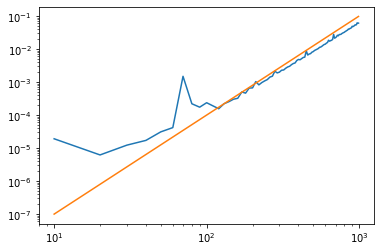

In [64]:
"import matplotlib.pyplot as plt
plt.loglog( nList, timeList )
plt.loglog( nList, 1e-10*np.array(nList)**3)
plt.show()